In [4]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np
import osmnx as ox
from ast import literal_eval

C:\Users\perry\AppData\Local\Temp\ipykernel_22376\402291515.py:68: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\perry\AppData\Local\Temp\ipykernel_22376\402291515.py:68: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


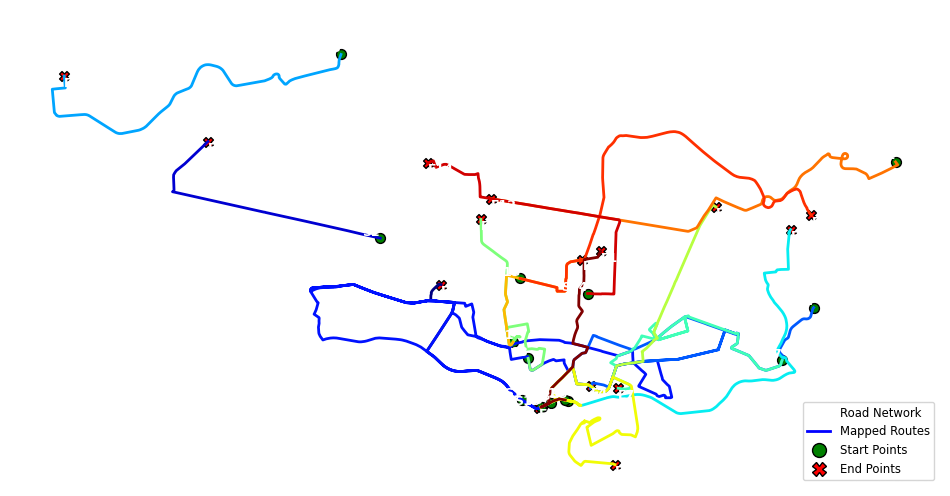

Image saved to data\Mapped_Trajectories_of_first_15_trips.png


In [5]:

def parse_mgeom(value):
    """Parse LINESTRING format into a LineString object."""
    try:
        if value.startswith("LINESTRING"):
            coords = value.replace("LINESTRING(", "").replace(")", "").split(",")
            coords = [(float(coord.split()[0]), float(coord.split()[1])) for coord in coords]
            return LineString(coords)
        return None
    except Exception as e:
        return None

def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

def visualize_first_15_routes(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    df = pd.read_csv(file_path)
    df['geometry'] = df['mgeom'].apply(parse_mgeom)
    df = df.dropna(subset=['geometry'])

    if df.empty:
        print("No valid geometries found.")
        return

    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first = True

    num_routes = min(15, len(gdf))
    colors = plt.cm.jet(np.linspace(0, 1, num_routes))

    # Calculate boundaries and plot routes
    for i, geometry in enumerate(gdf['geometry'].head(num_routes)):
        x, y = geometry.xy
        for lon, lat in zip(x, y):
            current_x_max, current_y_max, current_x_min, current_y_min, is_first = calculate_boundaries(
                current_x_max, current_y_max, current_x_min, current_y_min, is_first, lon, lat
            )

    if is_first:
        print("Could not calculate boundaries. Using default values.")
        current_x_min, current_x_max = -8.7, -8.5  
        current_y_min, current_y_max = 41.1, 41.3
    else:
        x_padding = (current_x_max - current_x_min) * 0.05
        y_padding = (current_y_max - current_y_min) * 0.05
        current_x_min -= x_padding
        current_x_max += x_padding
        current_y_min -= y_padding
        current_y_max += y_padding

    north, south, east, west = current_y_max, current_y_min, current_x_max, current_x_min
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        bgcolor='black',
        edge_color='white',
        node_size=0,
        edge_linewidth=0.5,  
        figsize=(12, 12)
    )

    # Plot the routes
    for i, geometry in enumerate(gdf['geometry'].head(num_routes)):
        label = f"Trip {i+1}"
        x, y = geometry.xy
        ax.plot(x, y, color=colors[i], linewidth=2, label=label)
        
        # Plot start and end points
        ax.scatter(x[0], y[0], color='green', marker='o', s=50, edgecolor='k')  # Start point
        ax.scatter(x[-1], y[-1], color='red', marker='X', s=50, edgecolor='k')  # End point
        
        # Annotate start and end points
        ax.text(x[0], y[0], f"S{i+1}", fontsize=9, fontweight='bold', color='white',
                verticalalignment='bottom', horizontalalignment='right')
        ax.text(x[-1], y[-1], f"E{i+1}", fontsize=9, fontweight='bold', color='white',
                verticalalignment='top', horizontalalignment='left')

    ax.set_title("First 15 Routes on Porto's Road Network with Mapped Trajectories", color='white', fontsize=15)
    ax.axis('off')  

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='white', lw=2, label='Road Network'),
        Line2D([0], [0], color='blue', lw=2, label='Mapped Routes'),
        Line2D([0], [0], marker='o', color='w', label='Start Points',
               markerfacecolor='green', markersize=10, markeredgecolor='k'),
        Line2D([0], [0], marker='X', color='w', label='End Points',
               markerfacecolor='red', markersize=10, markeredgecolor='k')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize='small')

    ax.set_xlim([current_x_min, current_x_max])
    ax.set_ylim([current_y_min, current_y_max])

    output_dir = 'data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'Mapped_Trajectories_of_first_15_trips.png')
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Image saved to {output_path}")

# Run the function with the specified file path
visualize_first_15_routes("data/map_matching_1500.csv")

In [16]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString
import os

def parse_mgeom(value):
    """Parse LINESTRING format into a LineString object."""
    try:
        if value.startswith("LINESTRING"):
            coords = value.replace("LINESTRING(", "").replace(")", "").split(",")
            coords = [(float(coord.split()[0]), float(coord.split()[1])) for coord in coords]
            return LineString(coords)
        return None
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

def visualize_first_15_routes(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    # Load and parse geometries
    df = pd.read_csv(file_path)
    df['geometry'] = df['mgeom'].apply(parse_mgeom)
    df = df.dropna(subset=['geometry'])
    if df.empty:
        print("No valid geometries found.")
        return

    # Initialize boundaries and color mapping for routes
    current_x_max = current_y_max = current_x_min = current_y_min = None
    is_first = True
    num_routes = min(15, len(df))
    colors = plt.cm.jet(np.linspace(0, 1, num_routes))

    # Calculate boundaries based on route data
    for i, geometry in enumerate(df['geometry'].head(num_routes)):
        x, y = geometry.xy
        for lon, lat in zip(x, y):
            current_x_max, current_y_max, current_x_min, current_y_min, is_first = calculate_boundaries(
                current_x_max, current_y_max, current_x_min, current_y_min, is_first, lon, lat
            )

    # Adjust boundaries with padding for the map view
    if is_first:
        current_x_min, current_x_max = -8.7, -8.5  
        current_y_min, current_y_max = 41.1, 41.3
    else:
        x_padding = (current_x_max - current_x_min) * 0.05
        y_padding = (current_y_max - current_y_min) * 0.05
        current_x_min -= x_padding
        current_x_max += x_padding
        current_y_min -= y_padding
        current_y_max += y_padding

    # Create a folium map centered on the calculated boundaries
    f = folium.Figure(width=1500, height=1000)
    fmap = folium.Map(location=[(current_y_max + current_y_min) / 2, (current_x_max + current_x_min) / 2],
                      zoom_start=13, max_bounds=True)
    fmap.add_to(f)
    fmap.fit_bounds([[current_y_min, current_x_min], [current_y_max, current_x_max]])

    # Plot each trajectory with optional lines and circle markers for each point
    PLOT_LINES = False  # Set this to True if you want to add lines between points
    for idx, geometry in enumerate(df['geometry'].head(num_routes)):
        feature_group = folium.FeatureGroup(name=f'Trip {idx + 1}')
        x, y = geometry.xy
        color = f'#{int(colors[idx][0]*255):02x}{int(colors[idx][1]*255):02x}{int(colors[idx][2]*255):02x}'

        # Add a polyline for the route if PLOT_LINES is enabled
        if PLOT_LINES:
            feature_group.add_child(folium.PolyLine(list(zip(y, x)), color=color, weight=3))

        # Plot each point in the trajectory as a circle marker
        for lat, lon in zip(y, x):
            feature_group.add_child(folium.CircleMarker(
                location=(lat, lon), radius=5, color=color, fill=True, fill_color=color, fill_opacity=1
            ))

        # Highlight start and end points with distinct colors
        feature_group.add_child(folium.CircleMarker(
            location=(y[0], x[0]), radius=7, color='green', fill=True, fill_color='green', fill_opacity=1))
        feature_group.add_child(folium.CircleMarker(
            location=(y[-1], x[-1]), radius=7, color='red', fill=True, fill_color='red', fill_opacity=1))

        fmap.add_child(feature_group)

    # Add layer control to toggle trips on/off
    folium.LayerControl().add_to(fmap)

    # Save the map as an HTML file
    output_dir = 'data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'Mapped_Trajectories_of_first_15_trips.html')
    fmap.save(output_path)

    print(f"Interactive map without network lines saved to {output_path}")

# Run the function with the specified file path
visualize_first_15_routes("data/map_matching_1500.csv")


Error parsing geometry: list index out of range
Error parsing geometry: IllegalArgumentException: point array must contain 0 or >1 elements

Error parsing geometry: IllegalArgumentException: point array must contain 0 or >1 elements

Interactive map without network lines saved to data\Mapped_Trajectories_of_first_15_trips.html


C:\Users\perry\AppData\Local\Temp\ipykernel_32784\3091693869.py:29: DtypeWarning: Columns (699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,9

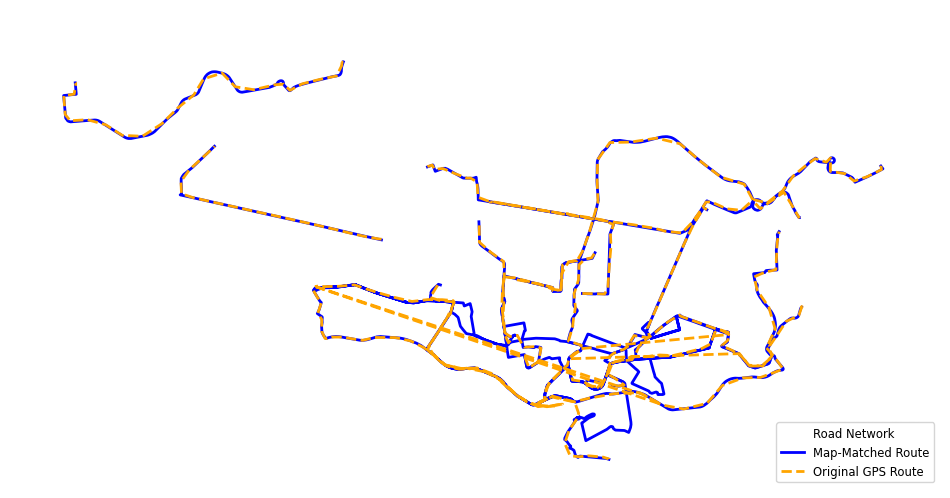

Image saved to data\Comparison_Original_vs_MapMatched.png


In [12]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np
import osmnx as ox
from ast import literal_eval

def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

def visualize_first_15_routes(map_matching_csv, original_trajectories_csv):
    if not os.path.exists(map_matching_csv) or not os.path.exists(original_trajectories_csv):
        print("One or both input files not found.")
        return

    # Load map-matched data
    df = pd.read_csv(map_matching_csv)
    def parse_mgeom(value):
        try:
            coords = literal_eval(value)
            if isinstance(coords, list) and all(isinstance(coord, list) and len(coord) == 2 for coord in coords):
                return LineString(coords)
            else:
                return None
        except:
            return None

    df['geometry'] = df['mgeom'].apply(parse_mgeom)
    df = df.dropna(subset=['geometry'])
    if df.empty:
        print("No valid geometries found.")
        return
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

    # Load original GPS data
    df_original = pd.read_csv(original_trajectories_csv, nrows=15)
    trajectories = []
    x_max = y_max = x_min = y_min = None
    is_first = True
    for polyline in df_original['POLYLINE']:
        polyline = polyline[2: -2]
        trajectory = [
            tuple(map(float, coord.split(',')))
            for coord in polyline.split('],[')
        ]
        for longitude, latitude in trajectory:
            x_max, y_max, x_min, y_min, is_first = calculate_boundaries(
                x_max, y_max, x_min, y_min, is_first, longitude, latitude
            )
        trajectories.append(trajectory)

    # Combined boundaries and road network
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    current_x_min, current_x_max = x_min - x_padding, x_max + x_padding
    current_y_min, current_y_max = y_min - y_padding, y_max + y_padding

    north, south, east, west = current_y_max, current_y_min, current_x_max, current_x_min
    G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        bgcolor='black',
        edge_color='white',
        node_size=0,
        edge_linewidth=0.5,
        figsize=(12, 12)
    )

    # Plot map-matched routes with standardized color (blue)
    for geometry in gdf['geometry'].head(15):
        x, y = geometry.xy
        ax.plot(x, y, color='blue', linewidth=2, label='Map-Matched Route' if gdf['geometry'].head(15).index[0] == geometry else "")

    # Overlay original GPS points with standardized color (orange) and dashed line
    for trajectory in trajectories[:15]:
        x_coords, y_coords = zip(*trajectory)
        ax.plot(x_coords, y_coords, linestyle='dashed', color='orange', linewidth=2, label='Original GPS Route' if trajectories.index(trajectory) == 0 else "")

    ax.set_title("Comparison of Original GPS Points and Map-Matched Routes", fontsize=15, color='white')
    ax.axis('off')

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='white', lw=2, label='Road Network'),
        Line2D([0], [0], color='blue', lw=2, label='Map-Matched Route'),
        Line2D([0], [0], linestyle='dashed', color='orange', lw=2, label='Original GPS Route')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize='small')

    # Save plot
    output_dir = 'data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'Comparison_Original_vs_MapMatched.png')
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Image saved to {output_path}")

# Call the function with the provided file paths
visualize_first_15_routes("data/map_matching.csv", "data/train-1500.csv")
